# Pairtools walkthrough

Welcome to the pairtools walkthrough. 

Pairtools is a tool for extraction of pairwise contacts out of sequencing chromosomes conformation capture data, such as Hi-C, Micro-C or MC-3C.
Pairtools is used for obtaining .cool files by [distiller](https://github.com/open2c/distiller-nf/blob/master/distiller.nf), and has many more applications (see single-cell walkthrough or phasing walkthrough). 

Here, we will cover the basic steps from raw reads to .cool file with binned contacts.

### Download raw data

"Raw" data, or .fastq files are generated by sequencing facilities or can be taken from public databases, such as SRA. We will take a sample from Rao et at al. 2017, human datasets.
To reduce computateion time, take 5 mln reads instead of full sample:

In [1]:
! fastq-dump SRR13849430 --gzip --split-spot --split-3 --minSpotId 0 --maxSpotId 5000000

Read 5000000 spots for SRR13849430
Written 5000000 spots for SRR13849430


In [2]:
! ls SRR13849430*.fastq.gz

SRR13849430_1.fastq.gz	SRR8058285_1.fastq.gz
SRR13849430_2.fastq.gz	SRR8058285_2.fastq.gz


In [3]:
%%bash
gzip -dc SRR13849430_1.fastq.gz | head -n 8

@SRR13849430.1 1 length=150
NTCTCAGCCTTTATAAGATAGAAGAGAGTTGGGACCTTGCTCTAAATTCTGCTTTAGCAAGGGACTTTTGTACCTGCTTTCTTCCTTTATCCAGATCTAAAAATAGTTTATATGCTGACAACTCCCTGATGTTATTCTTTGTAGTATTTG
+SRR13849430.1 1 length=150
#AAFFJJJJJJJJJJJAJAJJJJFJJJAFFFFFFA7A-FJ7JJJ-AJAJJF-<-JJFFJ7FJJF7FJJFJJ<JFAF<JJJJAJJJJA-AFJ-FJ-FF<7-A-7A-FFF<J-FJJJ<F7)A-F--7))))--77--7------A---7-7-
@SRR13849430.2 2 length=150
NAAAAGGTTTATCTCTGTGAGATGAAGCCACATAAAACCAAGCAGTTTCACAGAAACTTGTTTGTAGATTTTAAATCCGCACATCACAAAGCCATTTCACAGACAGCTTCTTTCTACTTTTTATCTGCGGCCCTTCCGTATTCCCGCATA
+SRR13849430.2 2 length=150
#AAFAJJFJJJJFAAFJA<JJJFJJFJJJJJFFJ-FF<FFJJJJJJ7AFFF<FJJ-<-F7<7<A-AF7AJAJ-A-7FF7JJJFJJFJJFFFFAJFJJ7-7-A-F--777FJFJF7---AAAF<AAA--))--))-<))-------)))7-


We next map the sequencing data to the reference genome.

### Install reference genome

Although you may download and build bwa index for any genome manually, `genompy` can do that for you automatically: 

In [ ]:
# Activate bwa plugin for genomepy:
! genomepy plugin enable bwa

In [ ]:
# Install hg38 genome by genomepy:
! genomepy install hg38

In [4]:
# Check the location of the genome:
! ls ~/.local/share/genomes/hg38/

hg38.blacklist.bed.gz  hg38.DpnII.bed  hg38.fa.fai    hg38.gaps.bed  README.txt
hg38_DpnII.bed	       hg38.fa	       hg38.fa.sizes  index


### Map data with bwa mem

Note that you may use [bwa mem2](https://github.com/bwa-mem2/bwa-mem2), which is x2 times faster. 
It [proved to produce](https://github.com/open2c/pairtools/discussions/118) results very similar to bwa mem.

In [5]:
# Map test data:
! bwa mem -t 5 -SP ~/.local/share/genomes/hg38/index/bwa/hg38.fa SRR13849430_1.fastq.gz SRR13849430_2.fastq.gz > test.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 333334 sequences (50000100 bp)...
[M::process] read 333334 sequences (50000100 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (3287, 41601, 3132, 3247)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (1474, 3107, 5770)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 14362)
[M::mem_pestat] mean and std.dev: (3761.23, 2688.41)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 18658)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (223, 289, 356)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 622)
[M::mem_pestat] mean and std.dev: (277.40, 91.07)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 755)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 

After mapping, you have .sam/.bam alignment file, which cannot be interpreted as pairs directly. You need to extract contacts from it:

In [7]:
%%bash 
samtools view test.bam | head -n 4

SRR13849430.1	121	chr12	78795720	60	53S97M	=	78795720	0	CAAATACTACAAAGAATAACATCAGGGAGTTGTCAGCATATAAACTATTTTTAGATCTGGATAAAGGAAGAAAGCAGGTACAAAAGTCCCTTGCTAAAGCAGAATTTAGAGCAAGGTCCCAACTCTCTTCTATCTTATAAAGGCTGAGAN	-7-7---A------7--77--))))7--F-A)7F<JJJF-J<FFF-A7-A-7<FF-JF-JFA-AJJJJAJJJJ<FAFJ<JJFJJF7FJJF7JFFJJ-<-FJJAJA-JJJ7JF-A7AFFFFFFAJJJFJJJJAJAJJJJJJJJJJJFFAA#	NM:i:1	MD:Z:96G0	AS:i:96	XS:i:21
SRR13849430.1	181	chr12	78795720	0	*	=	78795720	0	TTATATGCTGACGTCGTCCATTGTTGATTCTTTGTGGTCTGTGTTCCCTCTGAAGCTCTCTGTACTTGTATATACAATTAGGCACCAACAATTCAACATGGGTAGTTATTATACTGCTAAAGCGACCCCAGAGCGAACCGGGCTACCTTN	---7---7-7)))-7---7-----7-7<---7-)<)<-----)-)<77--7---)7-<7-7----A-F<<-AF7-A777--77-7-----7--<--7-F777-A7-7---<7--7<7-<--77-77--77--7-7A---7-7---FF<A#	MC:Z:53S97M	AS:i:0	XS:i:0
SRR13849430.2	73	chr8	43879758	60	75M75S	=	43879758	0	NAAAAGGTTTATCTCTGTGAGATGAAGCCACATAAAACCAAGCAGTTTCACAGAAACTTGTTTGTAGATTTTAAATCCGCACATCACAAAGCCATTTCACAGACAGCTTCTTTCTACTTTTTATCTGCGGCCCTTCCGTATTCCCGCATA	#AAFAJJFJJJJFAAFJA<JJJFJJF

### Contacts extraction

Challenges of contacts extraction solved by `pairtools`:

- multiple walks in each Hi-C read

- alignments spaced by short genomic distance may be reported as single alignment with a gap by bwa

- PCR and optical duplicates

#### pairtools parse

The next step is to parse .sam/.bam into pairs. `pairtools parse` automatically detect the file format.

Full parse documentation: https://github.com/open2c/pairtools/blob/master/doc/parsing.rst


In [1]:
%%bash
pairtools parse -o test.pairs.gz -c ~/.local/share/genomes/hg38/hg38.fa.sizes \
  --drop-sam --drop-seq --output-stats test.stats \
  --assembly hg38 --no-flip \
  --add-columns mapq \
  --walks-policy mask \
  test.bam

Parse will result in .pairs file. .pairs is a simple tabular format for storing DNA contacts detected in a Hi-C experiment. The detailed [.pairs specification](https://github.com/4dn-dcic/pairix/blob/master/pairs_format_specification.md) is defined by the 4DN Consortium.

In [2]:
%%bash
# Header
gzip -dc test.pairs.gz | head -n 5

## pairs format v1.0.0
#shape: whole matrix
#genome_assembly: hg38
#chromsize: chr1 248956422
#chromsize: chr10 133797422


In [3]:
%%bash
# Last lines of the header contain the list of columns:
gzip -dc test.pairs.gz | grep "#" | tail -n 5

#samheader: @SQ	SN:chrX	LN:156040895
#samheader: @SQ	SN:chrY	LN:57227415
#samheader: @PG	ID:bwa	PN:bwa	VN:0.7.17-r1188	CL:./bwa mem -t 5 -SP /home/agalicina/.local/share/genomes/hg38/index/bwa/hg38.fa SRR13849430_1.fastq.gz SRR13849430_2.fastq.gz
#samheader: @PG	ID:pairtools_parse	PN:pairtools_parse	CL:./pairtools parse -o test.pairs.gz -c /home/agalicina/.local/share/genomes/hg38/hg38.fa.sizes --drop-sam --drop-seq --output-stats test.stats --assembly hg38 --no-flip --add-columns mapq --walks-policy mask test.bam	PP:bwa	VN:1.0.0-dev1
#columns: readID chrom1 pos1 chrom2 pos2 strand1 strand2 pair_type mapq1 mapq2


In [4]:
%%bash 
# Body of the .pairs file
gzip -dc test.pairs.gz | grep -v "#" | head -n 5

SRR13849430.1	chr12	78795816	!	0	-	-	UN	60	0
SRR13849430.2	!	0	!	0	-	-	WW	60	0
SRR13849430.3	chr2	72005391	!	0	+	-	UN	60	0
SRR13849430.4	chr2	20530788	!	0	+	-	UN	60	0
SRR13849430.5	!	0	!	0	-	-	WW	0	0


#### pairtools sort

After parsing each pair is listed in the orderthat it appeared in the reads file. 
Sorting makes it more organised, and also helps to perform deduplication which cannot work on non-sorted files. 

In [5]:
%%bash
pairtools sort --nproc 5 -o test.sorted.pairs.gz test.pairs.gz

#### pairtools dedup


In [6]:
%%bash
pairtools dedup \
    --max-mismatch 3 \
    --mark-dups \
    --output \
        >( pairtools split \
            --output-pairs test.nodups.pairs.gz \
            --output-sam test.nodups.bam \
         ) \
    --output-unmapped \
        >( pairtools split \
            --output-pairs test.unmapped.pairs.gz \
            --output-sam test.unmapped.bam \
         ) \
    --output-dups \
        >( pairtools split \
            --output-pairs test.dups.pairs.gz \
            --output-sam test.dups.bam \
         ) \
    --output-stats test.dedup.stats \
    test.pairs.gz

In [7]:
%%bash
# Unique pairs:
gzip -dc test.nodups.pairs.gz | grep -v "#" | head -n 10

SRR13849430.513	chr20	23502312	chr20	23063544	+	+	RU	60	60
SRR13849430.1442	chr7	57224960	chrX	82818236	+	+	UU	60	30
SRR13849430.2378	chr5	115925933	chr21	24124840	+	+	UU	60	50
SRR13849430.2547	chr1	52097837	chr12	1888807	-	-	UU	60	60
SRR13849430.3015	chr17	74750879	chr11	117356318	+	-	UR	60	60
SRR13849430.3027	chr15	34977762	chr15	31897447	-	+	UR	11	60
SRR13849430.3406	chr11	1171960	chr9	121265592	+	-	UU	60	60
SRR13849430.3988	chr16	86824176	chr13	104521019	-	+	UU	60	17
SRR13849430.4030	chr17	73189645	chr4	49092470	-	+	UU	60	31
SRR13849430.4316	chr8	124329308	chr8	124336541	-	-	UU	60	60


In [8]:
%%bash
# Only duplicated  pairs:
gzip -dc test.dups.pairs.gz | grep -v "#" | head -n 10

SRR13849430.60371	chr2	44507613	chr7	116276932	-	+	DD	60	57
SRR13849430.67567	chr5	62425895	chr5	62425612	-	+	DD	60	60
SRR13849430.97623	chr3	162233323	chr3	162154449	-	+	DD	60	52
SRR13849430.108366	chr8	48691403	chr8	48872239	-	-	DD	60	60
SRR13849430.138622	chr16	8435050	chr16	6032751	+	-	DD	60	60
SRR13849430.146482	chr14	86385083	chr2	119648648	+	+	DD	60	60
SRR13849430.148232	chrX	21885792	chrX	21887418	+	-	DD	60	60
SRR13849430.149771	chr16	6646543	chr16	6648097	-	-	DD	60	60
SRR13849430.156983	chr4	55704089	chr4	76039070	+	+	DD	60	13
SRR13849430.157962	chr6	47656758	chr6	47748395	+	-	DD	60	35


#### pairtools select

Sometimes you may need certain types of pairs based on their properties, such as mapq, pair type, distance or orientation. 
For all these manipulations, there is `pairtools select` which requires a file and pythonic condition as an input:

In [9]:
%%bash 
pairtools select "mapq1>0 and mapq2>0" test.nodups.pairs.gz -o test.nodups.UU.pairs.gz

#### pairtools stats

Describe the types fo distance properties of pairs: 

In [28]:
%%bash
pairtools stats test.pairs.gz -o test.stats

### MultiQC

In [30]:
%%bash
multiqc test.stats


  /// MultiQC 🔍 | v1.12.dev0 (c3daccb)

|           multiqc | Search path : /home/agalicina/Open2C/pairtools_pre1/examples/test.stats


|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 1/1  


|         pairtools | parsing .stats file: test.stats
|         pairtools | Found 1 reports
/home/agalicina/soft/MultiQC/multiqc/modules/pairtools/pairtools.py:401: RuntimeWarning: invalid value encountered in true_divide
  _summary[cat] = _summary[cat] / _areas
|           multiqc | Compressing plot data
|            megaqc | Couldn't export data key 'report.general_stats_data'
|           multiqc | Previous MultiQC output found! Adjusting filenames..
|           multiqc | Use -f or --force to overwrite existing reports instead
|           multiqc | Report      : multiqc_report_4.html
|           multiqc | Data        : multiqc_data_4
|           multiqc | MultiQC complete


In [31]:
from IPython.display import IFrame

IFrame(src='./multiqc_report.html', width=1200, height=700)

### Load pairs to cooler
Finally, when you obtained a list of appropriate pairs, you may create coolers with it: 

In [13]:
%%bash
cooler cload pairs \
    -c1 2 -p1 3 -c2 4 -p2 5 \
    --assembly hg38 \
    ~/.local/share/genomes/hg38/hg38.fa.sizes:1000000 \
    test.nodups.UU.pairs.gz \
    test.hg38.1000000.cool

  is_cat = pd.api.types.is_categorical(bins["chrom"])

INFO:cooler.create:Writing chunk 0: /home/agalicina/Open2C/pairtools_pre1/examples/tmp0_0wda3c.multi.cool::0
INFO:cooler.create:Creating cooler at "/home/agalicina/Open2C/pairtools_pre1/examples/tmp0_0wda3c.multi.cool::/0"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.create:Merging into test.hg38.1000000.cool
INFO:cooler.create:Creating cooler at "test.hg38.1000000.cool::/"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:nnzs: [468683]
INFO:cooler.reduce:current: [468683]
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info


In [14]:
%%bash
cooler zoomify \
    --nproc 5 \
    --out test.hg38.1000000.mcool \
    --resolutions 1000000,2000000 \
    --balance \
    test.hg38.1000000.cool

INFO:cooler.cli.zoomify:Recursively aggregating "test.hg38.1000000.cool"
INFO:cooler.cli.zoomify:Writing to "test.hg38.1000000.mcool"
INFO:cooler.reduce:Copying base matrices and producing 2 new zoom levels.
INFO:cooler.reduce:Bin size: 1000000
INFO:cooler.reduce:Aggregating from 1000000 to 2000000.
  is_cat = pd.api.types.is_categorical(bins["chrom"])

INFO:cooler.create:Creating cooler at "test.hg38.1000000.mcool::/resolutions/2000000"
INFO:cooler.create:Writing chroms
INFO:cooler.create:Writing bins
INFO:cooler.create:Writing pixels
INFO:cooler.reduce:0 468683
INFO:cooler.create:Writing indexes
INFO:cooler.create:Writing info
INFO:cooler.cli.zoomify:Balancing zoom level with bin size 1000000
INFO:cooler.cli.balance:Balancing "test.hg38.1000000.mcool::resolutions/1000000"
INFO:cooler.balance:variance is 37206.68971415146
INFO:cooler.balance:variance is 2082.805159204234
INFO:cooler.balance:variance is 742.7371481963397
INFO:cooler.balance:variance is 232.9004212087261
INFO:cooler.bal

### Visualize coolers:

Based on [open2c vis example](https://github.com/open2c/open2c_examples/blob/master/viz.ipynb)

In [15]:
import cooler
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import cooltools.lib.plotting
from matplotlib.colors import LogNorm
import seaborn as sns

In [16]:
file = "test.hg38.1000000.mcool::/resolutions/1000000"

In [17]:
clr = cooler.Cooler(file)

In [18]:
# Define chromosome starts
chromstarts = []
for i in clr.chromnames:
    chromstarts.append(clr.extent(i)[0])

In [19]:
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

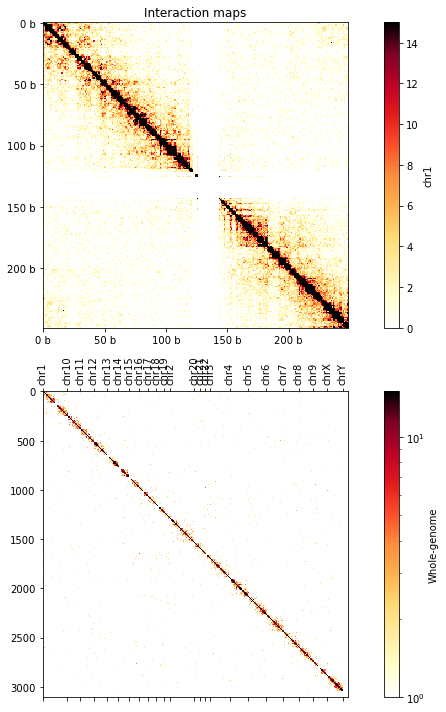

In [26]:
vmax = 15
norm = LogNorm(vmin=1, vmax=vmax)

f, axs = plt.subplots(
    figsize=(13, 10),
    nrows=2, 
    ncols=1,
    sharex=False, sharey=False)

ax = axs[0]
ax.set_title('Interaction maps')
im = ax.matshow(clr.matrix(balance=False).fetch('chr1'), vmax=vmax, cmap='fall'); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='chr1');

ax = axs[1]
im = ax.matshow(clr.matrix(balance=False)[:], norm=norm, cmap='fall'); 
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='Whole-genome');
ax.set_xticks(chromstarts,clr.chromnames, rotation=90);

format_ticks(axs[0], rotate=False)

plt.tight_layout()